In [1]:
suppressPackageStartupMessages({
    library(limma)
    # library(pcaMethods)
    # library(PEMM)
    # library(missForest)
    # library(mice)

    library(rrcovNA)
    library(imputeLCMD)
})

options(warn = -1)



impute.perseus <- function(x, width=0.3, shift=1.8) {
  # distributions are induced by measured values in each sample
  data.mean <- colMeans(x, na.rm = TRUE)
  data.sd <- matrixStats::colSds(x, na.rm = TRUE)
  n <- nrow(x)
  z <- rmvnorm(n, mean = data.mean - shift*data.sd , sigma = diag(data.sd*width))
  x[is.na(x)] <- z[is.na(x)]
  return(x)
}

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 200)
}

devtools::load_all("/stornext/General/data/academic/lab_davis/prot/benchmarking/msImpute/")


ℹ Loading msImpute



In [2]:
data <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD014777/HeLa_10_replicates_2hr/evidence.txt", 
                   stringsAsFactors = FALSE)




table(data$Type)
table(grepl("CON_|REV_", data$Leading.razor.protein))
table(data$Charge > 1)


data <- data[grep("CON_|REV_", data$Leading.razor.protein, invert=TRUE),]
data <- data[data$Charge > 1 & (data$Modifications %in% "Unmodified"),]
data$PeptideID <- paste0(data$Modified.sequence, data$Charge)
data$matrix.row.id <- paste(data$PeptideID, data$Leading.Razor.Protein, sep ="_")


genes <- data[,c("PeptideID","matrix.row.id", "Leading.razor.protein")]
genes <- genes[!duplicated(genes),]


y <- evidenceToMatrix(data[data$Type %in% "TIMS-MULTI-MSMS",])


y <- log2(y)
y <- y[rowSums(!is.na(y)) >=4,]

#ensure column names are allowed names
colnames(y) <- gsub("-","_", colnames(y))
genes <- genes[match(rownames(y), genes$PeptideID),]
rownames(y) <- genes$matrix.row.id



TIMS-MULTI-MATCH  TIMS-MULTI-MSMS 
          186399           448067 


 FALSE   TRUE 
616165  18301 


 FALSE   TRUE 
  1681 632785 

### Imputation

In [3]:
# long runs - pre-computed 

# message("LLS")
# Sys.time()
# y_lls <- llsImpute(t(y))
# y_lls <- t(completeObs(y_lls))

# message("Imputation in progress")
# message("RF")
# Sys.time()
# y_rf <- missForest(y)
# y_rf <- y_rf$ximp



# message("Imputation in progress (column-wise imputation)")
# message("mice")
# Sys.time()
# # From mice -----


# colnames(y) <- gsub("_","", colnames(y))
# colnames(y) <- NULL
# y_mice <- mice(y)
# y_mice <- complete(y_mice)



# message("EM")
# Sys.time()
# # from PEMM ----
# y_em <- PEMM_fun(y, phi=0)$Xhat


# message("bpca")
# Sys.time()
# # From pcaMethods --------
# y_bpca <- pca(y, nPcs=2, method="bpca")
# y_bpca <- completeObs(y_bpca)

# saveRDS(list(y_rf, y_mice, y_em, y_bpca, y_lls), file="impute_HeLa_10_replicate_sOa_filter4obs_noNorm.rds")

In [4]:
group <- as.factor(rep(1:2, each = 5))


y_msImpute <- msImpute(y, 
                       rank.max = 2,
                       method = "v2-mnar",
                       group = group
                       )







y_MLE <- impute.wrapper.MLE(y)
y_impSeq <- impSeq(y)
y_knn <- impute.wrapper.KNN(y, K = 15)

y_perseus <- impute.perseus(y)

sOa_imps <- readRDS("/stornext/Home/data/allstaff/h/hediyehzadeh.s/softImpute_low_rank_experimentation/impute_HeLa_10_replicate_sOa_filter4obs_noNorm.rds")



names(sOa_imps) <- c("RF","Mice","EM","BPCA","LLS")

sOa_imps <- sOa_imps[c("RF","Mice","EM","BPCA")]


mats <- list(
             "KNN"= y_knn,
             
             "impSeq" = y_impSeq,
             
             "barycenter" = y_msImpute, 
             
             "baseline" = y)





mats <- c(sOa_imps, mats)

Running msImpute version 2

Estimate distribution under MAR assumption

rank is 2

computing lambda0 ...

lambda0 is 3.94062296185414

fit the low-rank model ...

model fitted. 
Imputting missing entries ...

Imputation completed

Compute barycenter of MAR and NMAR distributions v2-mnar



Cluster size 44517 broken into 27450 17067 
Cluster size 27450 broken into 26558 892 
Cluster size 26558 broken into 25889 669 
Cluster size 25889 broken into 25192 697 
Cluster size 25192 broken into 8383 16809 
Cluster size 8383 broken into 5694 2689 
Cluster size 5694 broken into 2386 3308 
Cluster size 2386 broken into 1285 1101 
Done cluster 1285 
Done cluster 1101 
Done cluster 2386 
Cluster size 3308 broken into 2018 1290 
Cluster size 2018 broken into 1625 393 
Cluster size 1625 broken into 779 846 
Done cluster 779 
Done cluster 846 
Done cluster 1625 
Done cluster 393 
Done cluster 2018 
Done cluster 1290 
Done cluster 3308 
Done cluster 5694 
Cluster size 2689 broken into 899 1790 
Done cluster 899 
Cluster size 1790 broken into 754 1036 
Done cluster 754 
Done cluster 1036 
Done cluster 1790 
Done cluster 2689 
Done cluster 8383 
Cluster size 16809 broken into 15558 1251 
Cluster size 15558 broken into 8535 7023 
Cluster size 8535 broken into 4137 4398 
Cluster size 4137 br

### Differential abundance

processing RF



       (Intercept) group2
Down             0   1479
NotSig           0  42387
Up           44517    651


processing Mice



       (Intercept) group2
Down             0      0
NotSig           0  44515
Up           44517      2


processing EM



       (Intercept) group2
Down             0      0
NotSig           0  44517
Up           44517      0


processing BPCA



       (Intercept) group2
Down             0      0
NotSig           0  44517
Up           44517      0


processing KNN



       (Intercept) group2
Down             0      0
NotSig           0  44517
Up           44517      0


processing impSeq



       (Intercept) group2
Down             0      0
NotSig           0  44517
Up           44517      0


processing barycenter



       (Intercept) group2
Down             0      1
NotSig           0  44516
Up           44517      0


processing baseline



       (Intercept) group2
Down             0     36
NotSig           0  44222
Up           44517     18


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



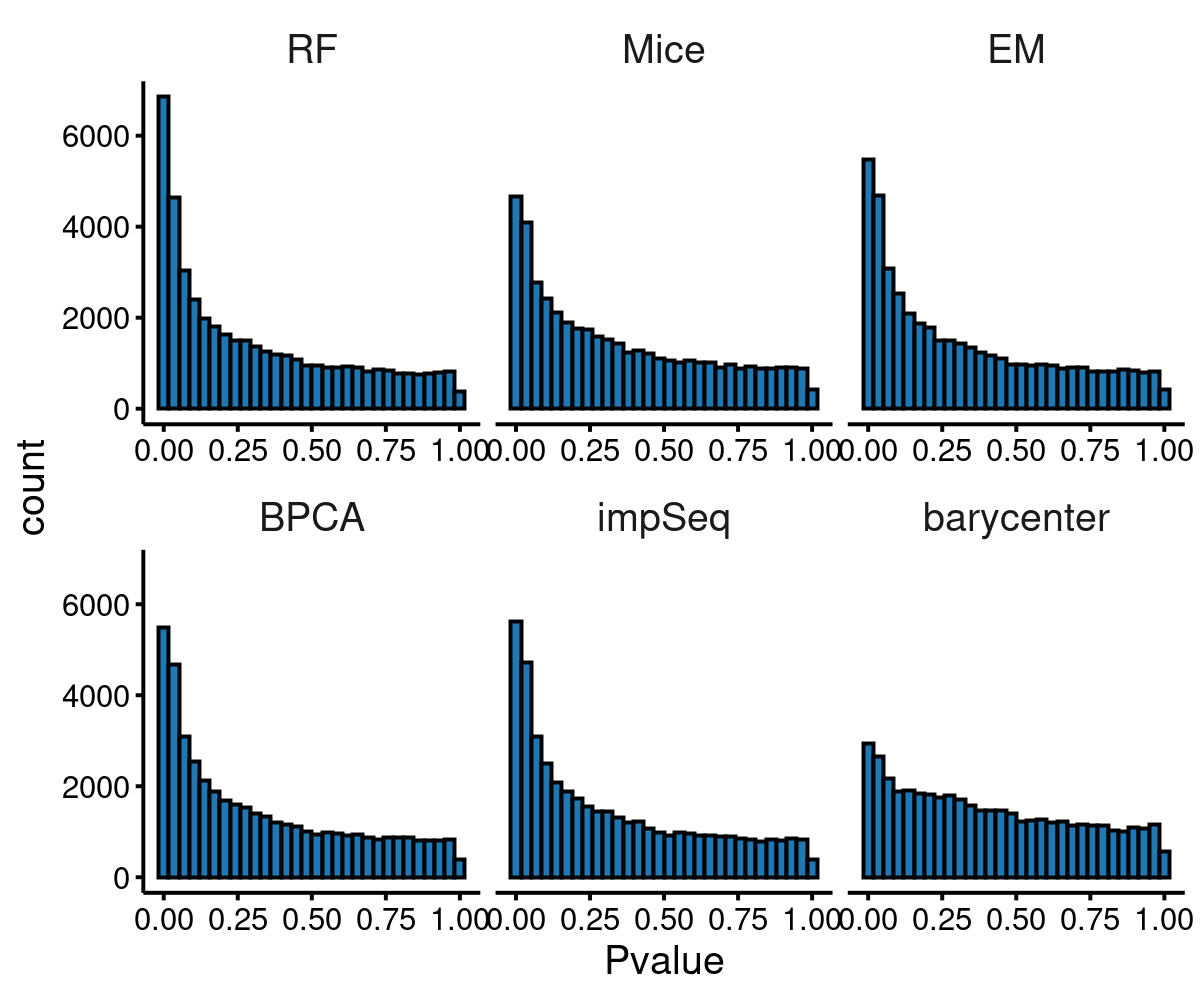

In [5]:
fig.size(5,6)


design <- model.matrix(~ group)

n_ups <- 500



fullTables <- list()

for(i in seq_along(mats)){
  message("processing ", names(mats)[i])
   E <- normalizeBetweenArrays(mats[[i]], method = "quantile")

   fit <- lmFit(E, design = design)

   fit <- eBayes(fit)
   print(summary(decideTests(fit)))

  
  
  
  

  fullTables[[names(mats)[i]]] <- fit$p.value[,2]
  

}



fullTables <- do.call(rbind, fullTables)
fullTables <- t(fullTables)

fullTables <- reshape2::melt(fullTables)

fullTables <- fullTables[grep("KNN|baseline", fullTables$Var2, invert = TRUE),]


library(ggplot2)

# png(file = "~/msImpute_pval_under_null.png", width=8,height=5,units="in",res=1200)
p <- ggplot(fullTables, aes(x=value)) +
  geom_histogram(fill = "#1F78B4", color = "black") +
  facet_wrap(.~Var2, scales = "free_x") + 
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5), 
        axis.text=element_text(colour="black", size = 11),
        axis.title = element_text(colour="black", size = 14),
        axis.ticks = element_line(colour = "black"),
        axis.line = element_line(colour = "black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(),
strip.text.x = element_text(size = 14)
        ) +
  xlab("Pvalue")

# print(p)
# dev.off()
p

### session information

In [6]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS:   /stornext/System/data/apps/R/R-4.1.2/lib64/R/lib/libRblas.so
LAPACK: /stornext/System/data/apps/R/R-4.1.2/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggplot2_3.3.4       msImpute_1.3.3      imputeLCMD_2.0     
 [4] impute_1.66.0       pcaMethods_1.84.0   Biobase_2.52.0     
 [7] BiocGenerics_0.38.0 norm_1.0-9.5        tmvtnorm_1.4-10    
[10] gmm_1.6-6        